In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import datetime as dt
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Embedding, LSTM, Flatten, Dense, Dropout, MaxPooling1D, Conv1D
from keras.callbacks import TensorBoard
from tensorboard import notebook
import time


%load_ext tensorboard

In [2]:
'''
# Extract the CSV files from the zipped folders
filename = 'True.csv.zip'
with ZipFile(filename, 'r') as zip:
    zip.extractall("./")
    print("Done with the True CSV")


filename = 'Fake.csv.zip'
with ZipFile(filename, 'r') as zip:
    zip.extractall("./")
    print("Done with the Fake CSV")
'''

'\n# Extract the CSV files from the zipped folders\nfilename = \'True.csv.zip\'\nwith ZipFile(filename, \'r\') as zip:\n    zip.extractall("./")\n    print("Done with the True CSV")\n\n\nfilename = \'Fake.csv.zip\'\nwith ZipFile(filename, \'r\') as zip:\n    zip.extractall("./")\n    print("Done with the Fake CSV")\n'

In [3]:
# Import the real news articles
true_news = pd.read_csv('True.csv')
true_news['class'] = 1
true_news.head()

,title,text,subject,date,class
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [4]:
# Import the fake news articles
fake_news = pd.read_csv('Fake.csv')
fake_news['class'] = 0
fake_news.head()

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [5]:
# Convert date field in true_news to a datetime
true_news['date'] = pd.to_datetime(true_news['date'])
true_news = true_news[true_news['date'].notnull()]
true_news.head()

,title,text,subject,date,class
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,1


In [6]:
# Convert date in fake_news to a datetime, if an entry is not a date, it will be turned into a NaT value and then dropped.
fake_news['date'] = pd.to_datetime(fake_news['date'], format='%B %d, %Y', errors='coerce')
fake_news = fake_news[fake_news['date'].notnull()]
fake_news.head()

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,0


In [10]:
# Extract the month and year from the timestamp to use as a bin for plotting
fake_news['month_and_year'] = (pd.DatetimeIndex(fake_news['date']).month).astype(str) + "-" + (pd.DatetimeIndex(fake_news['date']).year).astype(str)
fake_news = fake_news.sort_values('month_and_year')
fake_news['mANDy'] = fake_news['date'].dt.strftime("%Y-%m")
fake_news = fake_news.sort_values('mANDy')
fake_news.head()

,title,text,subject,date,class,month_and_year,mANDy
17363,WATCH HER SKI! AMERICAN TAXPAYERS ON THE HOOK ...,WOULDN T YOU LIKE TO KNOW THE GRAND TOTAL AND ...,Government News,2015-05-07,0,5-2015,2015-05
21793,BALTIMORE POLICE UNION WANTS AN INDEPENDANT PR...,The Police Union came out almost immediately a...,left-news,2015-05-01,0,5-2015,2015-05
15664,(VIDEO) JUDGE NAPOLITANO FILLS US IN ON ORDER ...,,politics,2015-05-20,0,5-2015,2015-05
21789,(VIDEO) ALAN DERSHOWITZ – SAD DAY FOR JUSTICE ...,You re At Forefront Of This Cause And As Youn...,left-news,2015-05-01,0,5-2015,2015-05
21794,(VIDEO) MADNESS IN THE STREETS: OVER 100 COPS ...,Bill O Reilly isn t my favorite and can be bel...,left-news,2015-05-01,0,5-2015,2015-05


In [11]:
# Extract the month and year from the timestamp to use as a bin for plotting
true_news['month_and_year'] = (pd.DatetimeIndex(true_news['date']).month).astype(str) + "-" + (pd.DatetimeIndex(true_news['date']).year).astype(str)
true_news['mANDy'] = true_news['date'].dt.strftime("%Y-%m")
true_news.head()

,title,text,subject,date,class,month_and_year,mANDy
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,1,12-2017,2017-12
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,1,12-2017,2017-12
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,1,12-2017,2017-12
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,1,12-2017,2017-12
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,1,12-2017,2017-12


Text(0.5, 1.0, 'Fake News Counts by Month and Year')

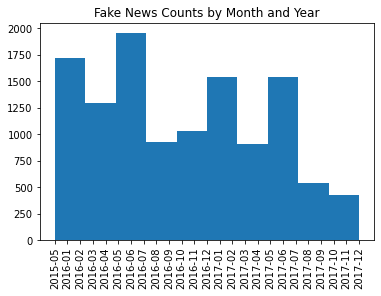

In [12]:
plt.hist(fake_news['mANDy'])
plt.xticks(rotation=90)
plt.title('Fake News Counts by Month and Year')

Text(0.5, 1.0, 'Fake News Count by Subject')

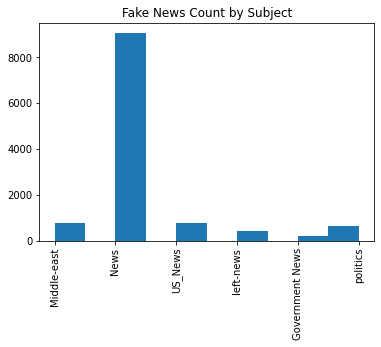

In [41]:
plt.hist(fake_news['subject'])
plt.xticks(rotation=90)
plt.title('Fake News Count by Subject')

In [42]:
# Concatenate the two datasets together
news = pd.concat([fake_news, true_news])
news.head()

,title,text,subject,date,class,month_and_year
23480,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,2016-01-12,0,1-2016
8668,Hilarious: Trevor Noah Has More Fun Than One ...,Another huge crowd of Americans tuned in last ...,News,2016-01-19,0,1-2016
8667,Rachel Maddow CRUSHES The GOP Fantasy That Re...,Republicans have revived an old and overused p...,News,2016-01-19,0,1-2016
8666,Photo Woman Posted Of Unsuspecting Target Cas...,A Target employee in Indiana has just gone vir...,News,2016-01-19,0,1-2016
8665,Seth Meyers: GOP ‘Sh*t All Over’ President Ob...,President Obama has been working for months to...,News,2016-01-19,0,1-2016


In [43]:
# Convert all words in the text field to lowercase in both datasets
news['text'] = news['text'].str.lower()
news['title'] = news['title'].str.lower()

In [44]:
# Remove all punctuation
news['text'] = news['text'].str.replace('[^\w\s]','')
news['title'] = news['title'].str.replace('[^\w\s]','')
news.head()

<ipython-input-44-8f477a891596>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  news['text'] = news['text'].str.replace('[^\w\s]','')
<ipython-input-44-8f477a891596>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  news['title'] = news['title'].str.replace('[^\w\s]','')


,title,text,subject,date,class,month_and_year
23480,10 us navy sailors held by iranian military s...,21st century wire says as 21wire predicted in ...,Middle-east,2016-01-12,0,1-2016
8668,hilarious trevor noah has more fun than one g...,another huge crowd of americans tuned in last ...,News,2016-01-19,0,1-2016
8667,rachel maddow crushes the gop fantasy that re...,republicans have revived an old and overused p...,News,2016-01-19,0,1-2016
8666,photo woman posted of unsuspecting target cas...,a target employee in indiana has just gone vir...,News,2016-01-19,0,1-2016
8665,seth meyers gop sht all over president obamas...,president obama has been working for months to...,News,2016-01-19,0,1-2016


In [45]:
# Instantiate a collection of stopwords
stop = stopwords.words('english')

In [15]:
# Remove all stopwords from the dataset
news['text'] = news['text'].apply(lambda x: [word for word in x if word not in stop])

In [16]:
# Instantiate a porterstemmer object for replacing words with their root word
ps = PorterStemmer()

In [17]:
# Replace words with their root words using the porter stemmer
news['text'] = news['text'].apply(lambda x : [ps.stem(y) for y in x])

In [18]:
# Isolate the text and the classification labels
req_data = news[['text','class']]
#articles = np.array(req_data['text'])
articles = req_data['text'].values() # Returns array, not list
labels = np.array(req_data['class'])

In [19]:
# Instantiate the tokenizer object
tokenizer = Tokenizer()

In [20]:
# Tokenize the words and add them to the word index and save the length of the word index for the embedding layer later on
tokenizer.fit_on_texts(articles)
word_index = tokenizer.word_index
vocab_size = len(word_index)

In [21]:
# Converting the text to an array of integers with a max length of it's number of words
text_arrays = tokenizer.texts_to_sequences(articles)

In [46]:
# Adding additional 0's as padding the matricies to ensure all matricies are the same size
padded_matrix = np.array(pad_sequences(text_arrays, padding='post'))

In [48]:
# Creating model
model = tf.keras.Sequential()
model.add(Embedding(vocab_size+1, 100))
model.add(Dropout(0.7))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(20, return_sequences=True))
model.add(LSTM(20))
model.add(Dropout(0.7))
model.add(Dense(512))
model.add(Dropout(0.7))  
model.add(Dense(256))
model.add(Dense(1, activation='sigmoid'))

In [49]:
# Compiling the model
model.compile(loss="binary_crossentropy", 
              metrics = ['accuracy', "Precision", "Recall"], 
              optimizer='rmsprop')

In [50]:
# Show the model's architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         5000      
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 20)          6800      
_________________________________________________________________
lstm_3 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)               

In [51]:
# Creating a place to save the model's logs for use in tensorboard
NAME = 'fake-news-identifier-{}'.format(time.time())
#NAME = 'testing_2_33_6_27'
tensorboard = TensorBoard(log_dir='./logs/fake-news/{}'.format(NAME))

# Showing tensorboard using the logs
%tensorboard --logdir './logs/fake-news/{}'.format(NAME)

Reusing TensorBoard on port 6006 (pid 13196), started 2 days, 7:59:46 ago. (Use '!kill 13196' to kill it.)

In [27]:
# Fit the model using the processed data
history = model.fit(padded_matrix, 
          labels,
          epochs=3,
          validation_split=.2,
          callbacks=[tensorboard])

Epoch 1/3
833/833 [==============================] - 11295s 14s/step - loss: 0.6920 - accuracy: 0.5388 - precision: 0.5515 - recall: 0.8783 - val_loss: 0.6619 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/3
833/833 [==============================] - 11472s 14s/step - loss: 0.6885 - accuracy: 0.5510 - precision: 0.5535 - recall: 0.9730 - val_loss: 0.4563 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/3
833/833 [==============================] - 11650s 14s/step - loss: 0.6902 - accuracy: 0.5482 - precision: 0.5485 - recall: 0.9984 - val_loss: 0.6268 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
